In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp

In [ ]:
import faraway.datasets.swiss
swiss = faraway.datasets.swiss.load()
swiss.head()

In [3]:
print(faraway.datasets.swiss.DESCR)


Swiss Fertility and Socioeconomic Indicators (1888) Data

Description:

     Standardized fertility measure and socio-economic indicators for
     each of 47 French-speaking provinces of Switzerland at about 1888.

Variables:

     A data frame with 47 observations on 6 variables, _each_ of which
     is in percent, i.e., in [0, 100].

       Fertility         Ig,‘common standardized fertility measure’      
                                                                               
       Agriculture       % of males involved in agriculture 
                               as occupation 
       Examination       % draftees receiving highest mark 
                               on army examination 
       Education         % education beyond primary school for draftees. 
       Catholic          % ‘catholic’ (as opposed to ‘protestant’).      
       Infant.Mortality  live births who live less than 1year.           
      
     All variables but ‘Fertility’ give proportions of the 

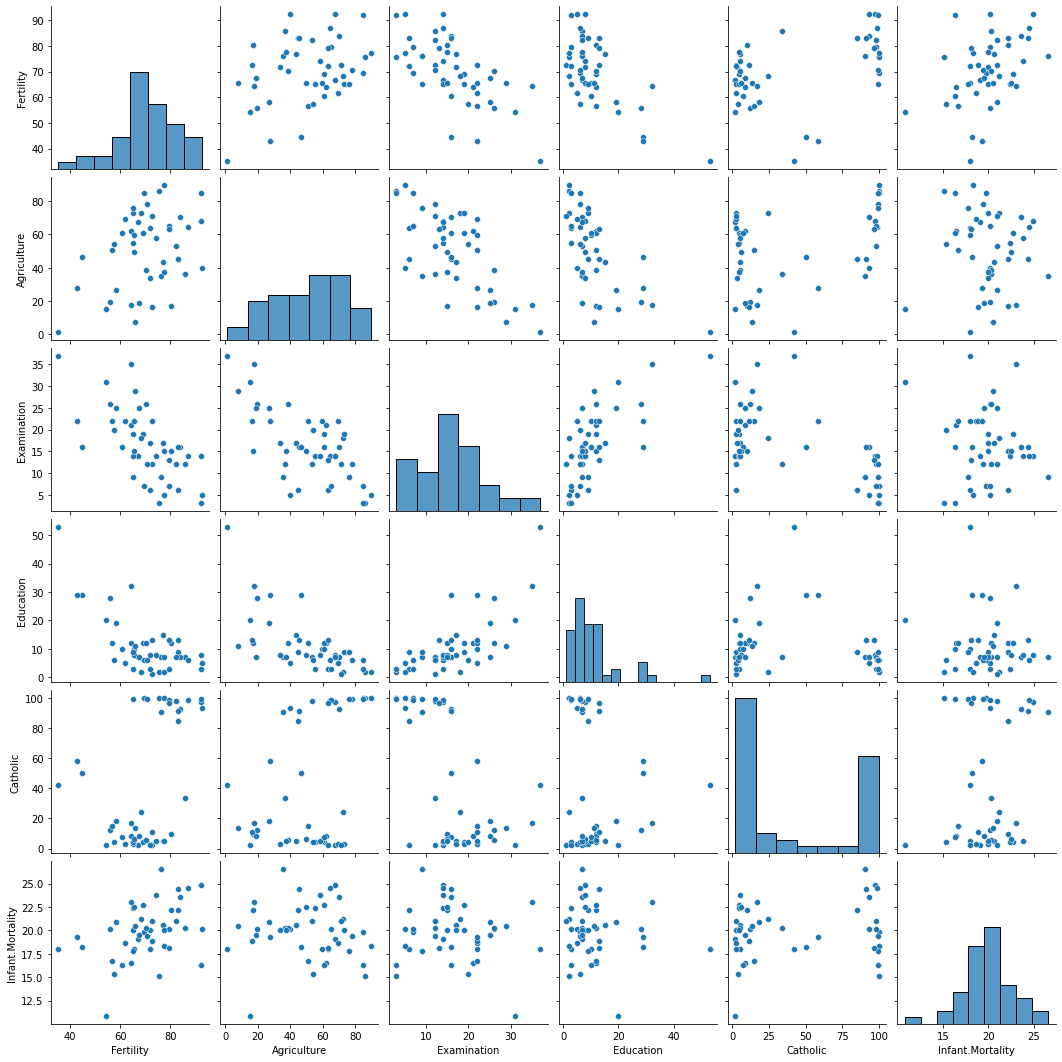

In [4]:
sns.pairplot(swiss)

TODO: find out how to do scatter with label for every predictor

In [7]:
swiss.corr()["Fertility"].sort_values(ascending=False)

Fertility           1.000000
Catholic            0.463685
Infant.Mortality    0.416556
Agriculture         0.353079
Examination        -0.645883
Education          -0.663789
Name: Fertility, dtype: float64

First group 
 Fertility           1.000000
Infant.Mortality    0.296830
Examination         0.080341
Education          -0.041663
Catholic           -0.254748
Agriculture        -0.334519
Name: Fertility, dtype: float64


Fertility           1.000000
Infant.Mortality    0.426341
Agriculture         0.226440
Examination        -0.546465
Catholic           -0.557963
Education          -0.712694
Name: Fertility, dtype: float64

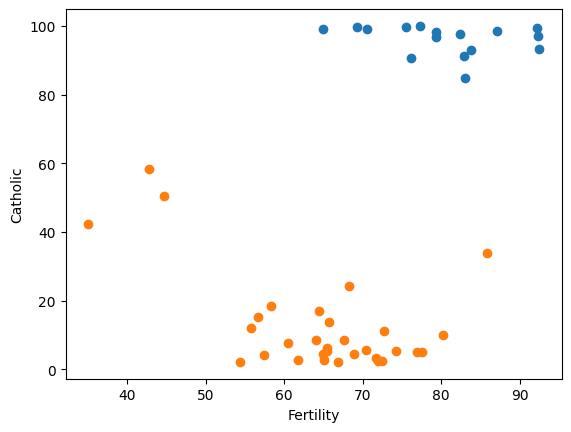

In [19]:
f, ax = plt.subplots(1, 1)

first_group = swiss[swiss["Catholic"] > 60]
second_group = swiss[swiss["Catholic"] < 60]

ax.scatter(first_group["Fertility"], first_group["Catholic"])
ax.scatter(second_group["Fertility"], second_group["Catholic"])

ax.set_ylabel("Catholic")
ax.set_xlabel("Fertility")

print(
    "First group \n",
    first_group.corr()["Fertility"].sort_values(ascending=False),
)
second_group.corr()["Fertility"].sort_values(ascending=False)


In [25]:
swiss["first_group"] = swiss.index.map(lambda x: x in first_group.index)

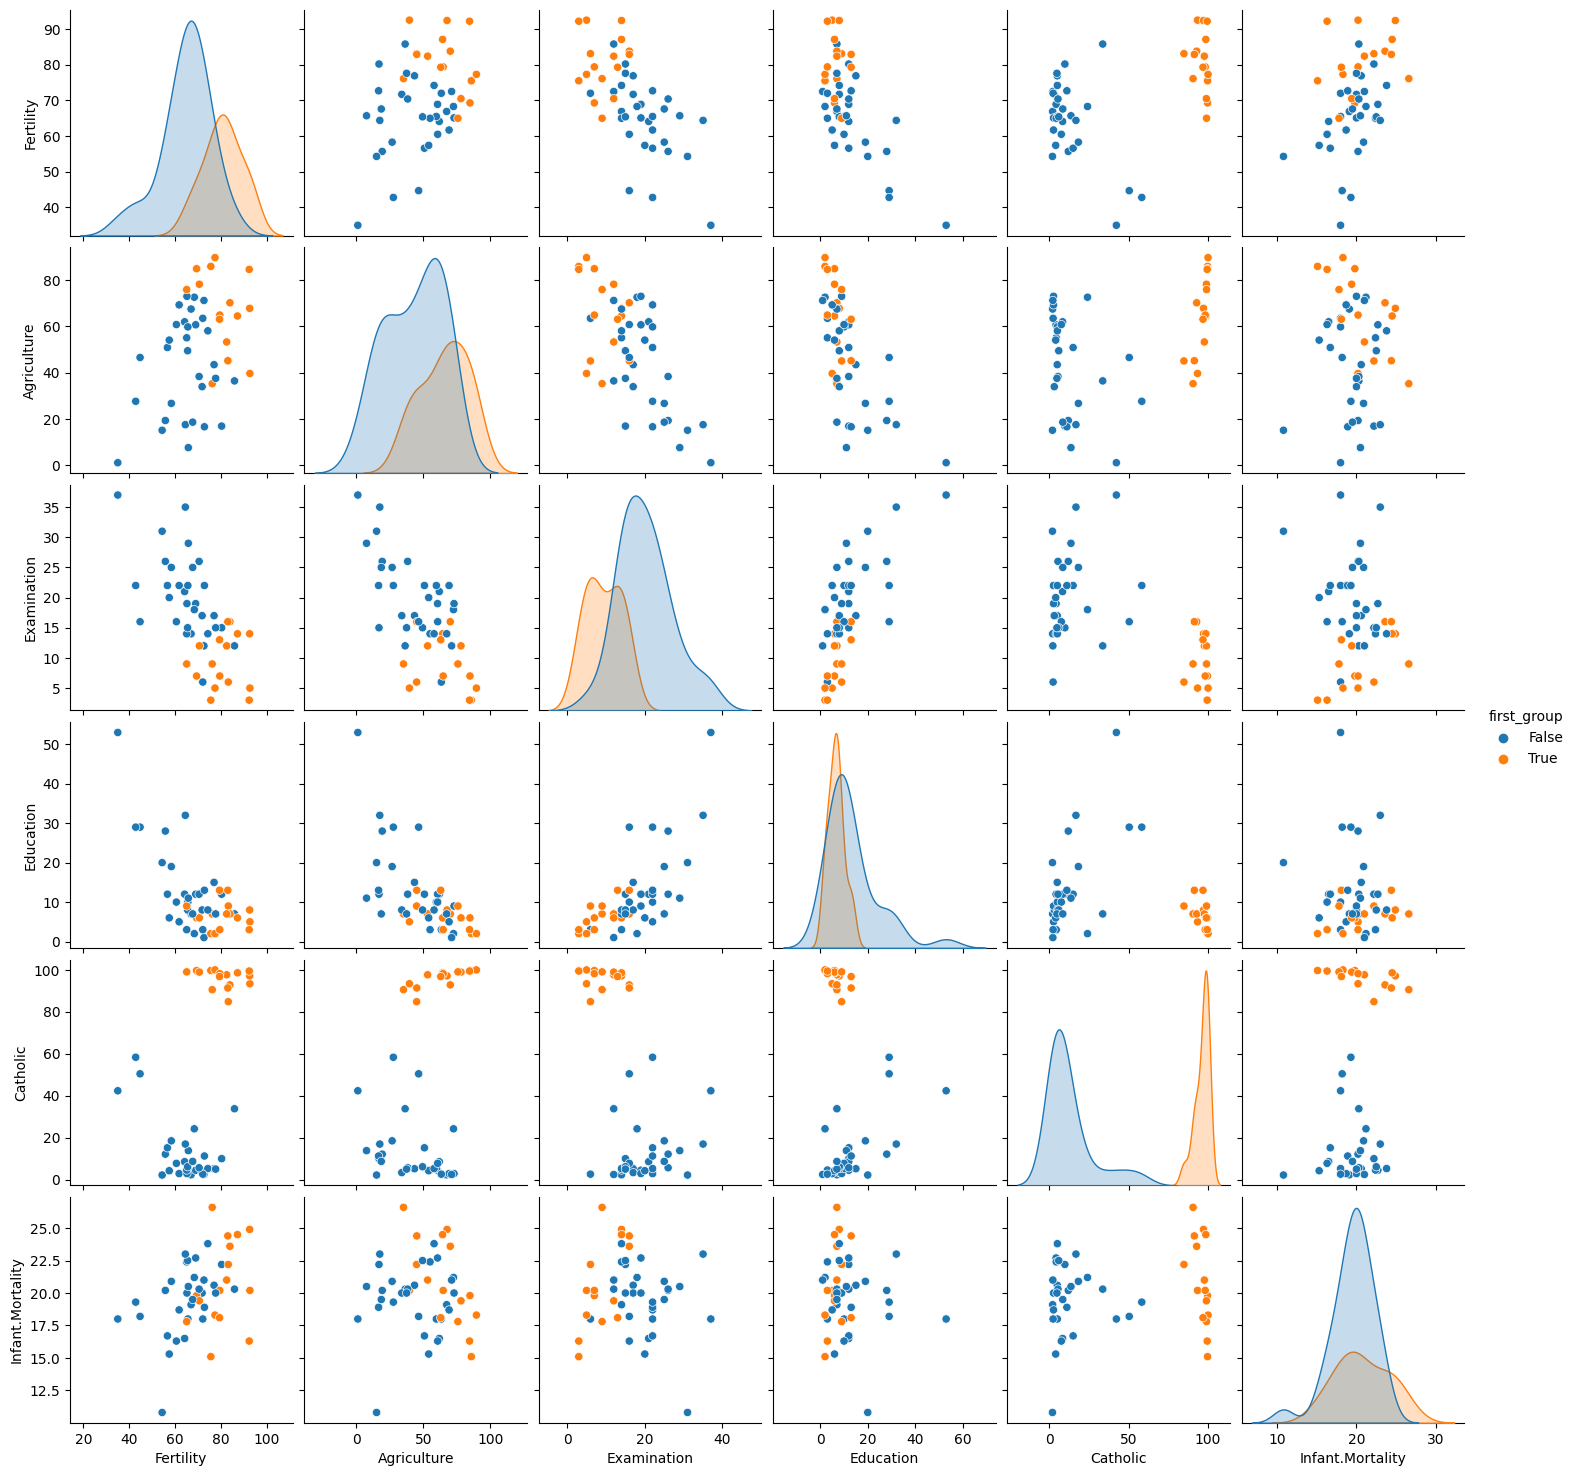

In [35]:
sns.pairplot(
    swiss, 
    hue="first_group",
)

In [38]:
swiss.groupby("first_group").describe()["Fertility"]

,count,mean,std,min,25%,50%,75%,max
first_group,,,,,,,,
False,31.0,64.770968,10.854283,35.0,59.40,65.5,71.850,85.8
True,16.0,80.550000,8.229945,65.0,75.95,80.9,84.625,92.5


In [40]:
swiss.rename(columns={"Infant.Mortality": "InfMortality"}, inplace=True)
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,InfMortality,first_group
0,80.2,17.0,15,12,9.96,22.2,False
1,83.1,45.1,6,9,84.84,22.2,True
2,92.5,39.7,5,5,93.40,20.2,True
3,85.8,36.5,12,7,33.77,20.3,False
4,76.9,43.5,17,15,5.16,20.6,False


In [46]:
import faraway.utils

lmod = smf.ols(
    "Fertility ~ Agriculture + Examination + Education + Catholic + InfMortality",
    data = swiss
).fit()
lmod.sumary()

              coefs stderr tvalues pvalues
Intercept    66.915 10.706    6.25  0.0000
Agriculture  -0.172  0.070   -2.45  0.0187
Examination  -0.258  0.254   -1.02  0.3155
Education    -0.871  0.183   -4.76  0.0000
Catholic      0.104  0.035    2.95  0.0052
InfMortality  1.077  0.382    2.82  0.0073

n=47 p=6 Residual SD=7.165 R-squared=0.71


In [47]:
%run utils.ipynb

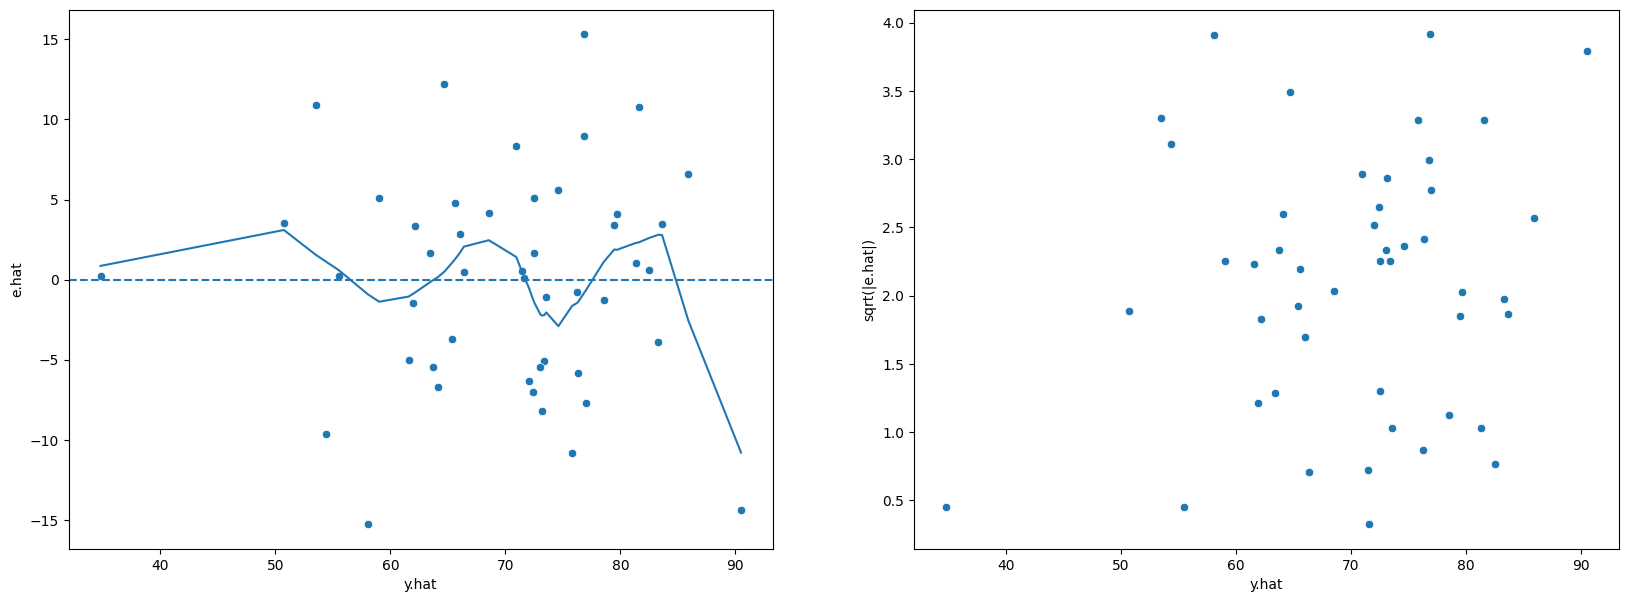

In [56]:
lowess = sm.nonparametric.lowess
f, ax = resid_yhat_plot(lmod)
smoothed = lowess(lmod.resid, lmod.fittedvalues, frac=1./3)
ax[0].plot(smoothed[:, 0], smoothed[:, 1])

In [58]:
diagv = lmod.get_influence()

In [60]:
rstand = diagv.resid_studentized_internal
np.std(rstand)

1.0033465054754958

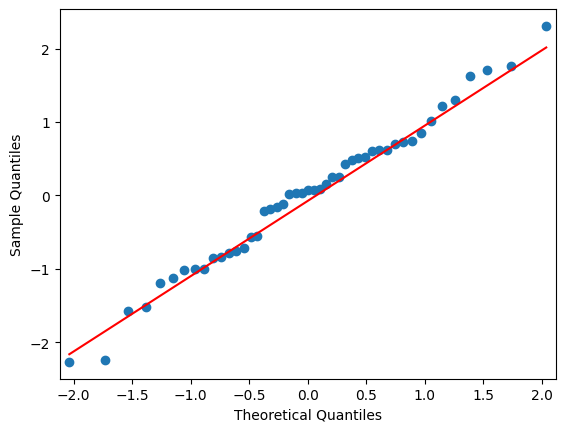

In [63]:
_ = sm.qqplot(rstand, line="q")

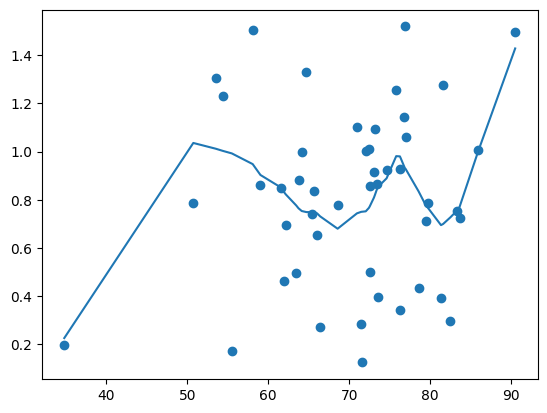

In [65]:
rstand_tr = np.sqrt(abs(rstand))
smoothed = lowess(rstand_tr, lmod.fittedvalues, frac=1./3)

f, ax = plt.subplots(1, 1)
ax.scatter(lmod.fittedvalues, rstand_tr)
ax.plot(smoothed[:, 0], smoothed[:, 1])

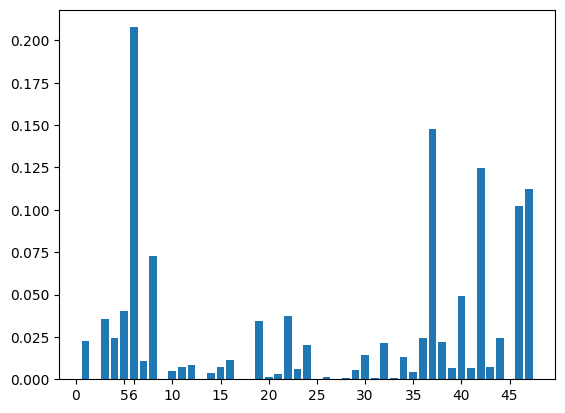

In [95]:
cooks = diagv.cooks_distance[0]
f, ax = plt.subplots(1, 1)
ix = np.arange(1, swiss.shape[0] + 1)
ix_ticks = np.arange(0, swiss.shape[0] + 1, 5)

ax.bar(ix, height=cooks)
_ = plt.xticks(list(ix_ticks) + [cooks.argmax()+1])

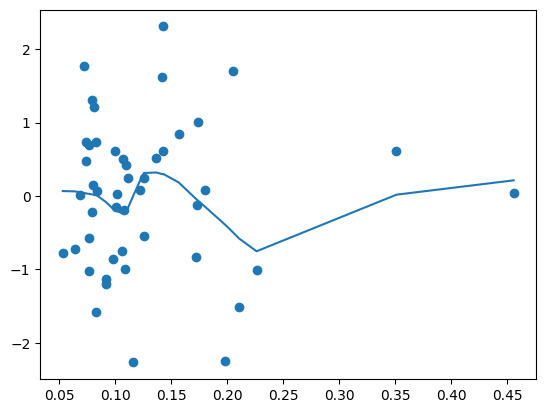

In [97]:
lev = diagv.hat_matrix_diag
f, ax = plt.subplots(1, 1)

smoothed = lowess(rstand, lev)
ax.scatter(lev, rstand)
ax.plot(smoothed[:, 0], smoothed[:, 1])

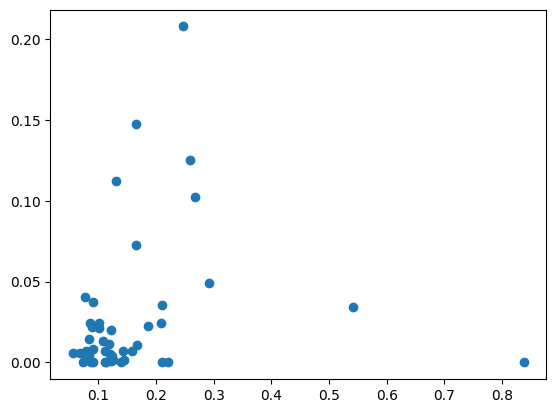

In [98]:
lev = diagv.hat_matrix_diag
f, ax = plt.subplots(1, 1)

ax.scatter(lev/(1-lev), cooks)